In [4]:
# !jupyter nbconvert --to slides week6.ipynb --post serve
# http://127.0.0.1:8000/week6.slides.html?print-pdf

<p style="text-align: center; font-size: 192%"> Computational Finance </p>
<img src="img/ABSlogo.svg" alt="LOGO" style="display:block; margin-left: auto; margin-right: auto; width: 90%;">
<p style="text-align: center; font-size: 150%"> Week 6: Monte Carlo Methods </p>
<p style="text-align: center; font-size: 75%"> <a href="#copyrightslide">Copyright</a> </p>

# Last week: Binomial Trees

* **Binomial trees** are a numerical method to price derivatives by constructing a replicating portfolio, assuming that the price will go up or down at discretized time points, and no arbitrage.
* The price of a derivative is the **expected discounted payoff**, under risk-neutral probabilities.
* To implement in Python, we need to calibrate the tree's parameters to the data.
* Speed can be improved in two ways:
	* More efficient code using **vectorization**;
	* **`Numba`** compiler.
* The **Black-Scholes** formula arises in the limit of the binomial tree's expression for European options.
* **Implied volatility** is the volatility that matches the observed prices to the Black-Scholes price. 
    * The smile pattern indicates deviations from Black-Scholes assumptions.

# This week: Monte Carlo Methods
* Brownian Motion
* Simulating the Brownian Motion
* Ito Processes
* Ito's Lemma
* The Black-Scholes Model
* Monte Carlo Pricing
* Application: Asian Options
* Code Optimization


* **Deadline assignment 2**: Sunday 12 December, 23:59

# Monte Carlo Methods
## Brownian Motion
* We saw last week that the binomial tree implies for $X_t\equiv \log S_t$ that

$$
X_{i\Delta t}=X_{(i-1)\Delta t}+R_i \Longleftrightarrow
\Delta X_{t} = R_i,\tag{$\dagger$}
$$

$\quad \;$ where $R_i=\log u$ or $R_i=\log d$, with probabilities $\mathbb{Q}[u]$ and $\mathbb{Q}[d]$. 
* Equation ($\dagger$) is a *stochastic difference equation*.
* Its *solution* 
$$
X_T=\log S_0 +\sum_{i=1}^N R_i=\log S_0 +\sigma \sqrt{\Delta t}(2k-N)
$$
is called a *binomial process*, or in the special case with
$\mathbb{E}[R_i]=0$, a *random walk*.


* We saw that if we let $N\rightarrow\infty$ (so that $\Delta t \rightarrow 0$),
$$
X_T-X_0\stackrel{d}{\rightarrow}N(\mu T,\sigma^2 T),\quad \mu\equiv r-\frac{1}{2}\sigma^2.
$$
* The argument can be repeated for every $X_t, t\leq T$, showing that
$$
X_t-X_0\stackrel{d}{\rightarrow}N(\mu t,\sigma^2 t),
$$
and that for any $0\lt t\lt T$, $X_t-X_0$ and $X_T-X_t$ are independent.
* As $\Delta t\rightarrow 0$, $\{X_t\}_{t\geq 0}$ becomes a continuous time process: the indexing set is now given by the entire positive real line.
* This continuous time limit (with $\mu=0$ and $\sigma^2=1$) is called *Brownian motion*, or *Wiener process*.
* From now on, rather than modelling in discrete time and then letting $\Delta t \rightarrow 0$, we will directly model in continuous time, using Brownian motion as a building block.


* Definition of (standard) *Brownian Motion*:
Stochastic process $\{W_{t}\}_{t\geq 0}$ satisfying
  * $W_{0}=0$;
  * The increments $W_{t} - W_s$ are independent for all $0 \le s < t$;
  * $W_{t} - W_s \sim N(0,t-s)$ for all $0 \le s \le t$;
  * Continuous sample paths.

* Simple variation of a standard Brownian motion are:
 * $X_{t}=\sigma W_{t}$ is Brownian motion with $\mathbb{E}[X_t]=0$ and $\mathrm{Var}[X_t]=\sigma^{2}t$.

 * The restriction that a process starts at zero may be loosened by considering $X_{t}=X_{0}+\sigma W_{t}$ such that $\mathbb{E}[X_t]=X_{0}$ and $\mathrm{Var}[X_t]=\sigma^{2}t$.


* Properties of Brownian Sample Paths:
  * *Continuity*: by assumption, and also $W_{t+\Delta t}-W_{t}\sim N(0,\Delta t)\rightarrow 0$ as $\Delta t \rightarrow 0$;
  * *Nowhere differentiability*: intuitively, this is seen from
$$
\frac{W_{t}-W_{t-\Delta t}}{\Delta t}\sim N\left( 0,\frac{1}{\Delta t}\right) ,\quad \frac{%
W_{t+\Delta t}-W_{t}}{\Delta t}\sim N\left( 0,\frac{1}{\Delta t}\right) ;
$$
left and right difference quotients do not have (common) limit as $\Delta t \rightarrow 0$ but random variables with an infinite variance.
  * *Self-similarity*: Zooming in on a Brownian motion yields another Brownian motion: for any $c>0$, $X_{t}=\sqrt{c}W_{t/c}$ is
a Brownian motion.



## Simulating Brownian Motion
* In order to simulate Brownian Motion, we need to discretize it. As usual, split the time interval $[0,T]$ into $N$ parts of length $\Delta t=T/N$ and let $t_{i}\equiv i\Delta t$.


* As in ($\dagger$), let 
$$
W_{i\Delta t}=W_{(i-1)\Delta t}+R_i \Longleftrightarrow \Delta W_{t} = R_{i},
$$
but where now we model $R_{i}$ as normal rather than binomial: 
$$
R_{i}=\sqrt{\Delta t}\cdot Z_i,\quad Z_i\sim\mathrm{N}(0, 1).
$$


* As a slight generalization, a *Brownian motion with drift* is obtained from
$$
\Delta X_t \equiv  X_{i\Delta t}-X_{(i-1)\Delta t} =\mu\Delta t+\sigma\Delta W_{t}=\mu\Delta t+\sigma\sqrt{\Delta t} Z_i,
$$
and where we allow $X_0$ to be an arbitrary value.
* This implies
$$
X_t\equiv X_0+\mu t +\sigma W_t,
$$
so that $\mathbb{E}[X_t]=X_{0}+\mu t$, $\mathrm{Var}[X_t]=\sigma^{2}t$. Hence the average upwards (or downwards if $\mu<0$) tendency over a time interval $\Delta t$ is $\mu \Delta t$.

* In order to implement this, we need a way of drawing random samples from the normal distribution.
* Computers are deterministic machines. They cannot generate true random numbers.
* Instead, they construct sequences of pseudo-random numbers from a specified distribution that *look* random, in the sense that they pass certain statistical tests.
  * E.g., NumPy's `np.random.randn(d0[, d1, ...]) ` constructs an array of standard normal pseudo random numbers.
* Random number generators use a *seed* value for initialization. Given the same seed, the same pseudo-random sequence will be returned.
* NumPy picks the seed automatically. To force it to use a specific seed, use `np.random.seed(n)`. Putting this line at the beginning of your Monte-Carlo program ensures that you get exactly the same results every time the program is run.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import numpy as np
def bmsim(T, N, X0=0, mu=0, sigma=1):
    """Simulate a Brownian motion path."""
    deltaT = float(T)/N
    tvec = np.linspace(0, T, N+1)
    z = np.random.randn(N+1)  #N+1 is one more than we need, actually. This way we won't have to grow dX by X0. 
    dX = mu*deltaT + sigma*np.sqrt(deltaT)*z  #X[j+1]-X[j]=mu*deltaT + sigma*np.sqrt(deltaT)*z[j].
    dX[0] = 0.
    X = np.cumsum(dX)
    X += X0    
    return tvec, X
bmsim(1, 1000)

(array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ]),
 array([ 0.        , -0.02925276, -0.01212648, ..., -0.80075589,
        -0.831987  , -0.85452713]))

In [7]:
np.random.seed(0)
tvec, W = bmsim(1, 1000)
W = pd.Series(W, index=tvec)
W.plot()
plt.title('Simulated Brownian Motion Path')
plt.xlabel("$t$"); plt.ylabel("$W_t$");
plt.savefig("img/BMpath.svg"); plt.close()

<img src="img/BMpath.svg" alt="Simulated Brownian Motion Path" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

## Ito Processes
* Ito processes generalize Brownian motion with drift by allowing the drift and volatility to be time-varying:
$$
\Delta X_t\equiv X_{i\Delta t}-X_{(i-1)\Delta t}=\mu_{t_{i-1}} \Delta t + \sigma_{t_{i-1}} \Delta W_t.
$$
* We allow $\mu_{t_i}$ and $\sigma_{t_i}$ to be stochastic; e.g., they may depend on $X_{i-1}$, as in 
$$
\Delta X_t=\mu(t_{i-1},X_{i-1}) \Delta t + \sigma(t_{i-1}, X_{i-1}) \Delta W_t.
$$
* One can show that under appropriate conditions, the process has a well-defined limit as $N\rightarrow\infty$ (so that $\Delta t \rightarrow 0$), for which we write
$$
d X_t= \mu(t,X_t) dt + \sigma(t, X_t) d W_t.
$$
This is known as a stochastic differential equation (SDE).
* If $\sigma_t$ is stochastic, then the distribution of $X_T$ implied by the SDE is no longer normal. One can show that if $N$ is large enough, then this distribution is correctly reproduced by the discretized version (which is then known as as the *Euler approximation*).

* Remark: in continuous time, a process $\{X_{t}\}_{t\geq 0}$ is a *martingale* if
  * $\mathbb{E}[|X_{t}|]<\infty $, for all $t\ge 0$; 
  * $\mathbb{E}[X_{t}|\mathcal{F}_{s}]=X_{s}$, for all $t>s\ge 0$,
where $\mathcal{F}_{t}$ denotes the information on $X_t$ up to time $t$.


* An Ito process is a martingale *if and only if* the drift is zero, because (using $s=t_{i-1}$)

\begin{align*}
\mathbb{E}[\Delta X_{t}|\mathcal{F}_{t_{i-1}}] &=\mathbb{E}[\mu(t_{i-1},X_{i-1}) \Delta t + \sigma(t_{i-1}, X_{i-1}) \Delta W_t|\mathcal{F}_{t_{i-1}}]\\&=\mu(t_{i-1},X_{i-1}) \Delta t + \sigma(t_{i-1}, X_{i-1}) \mathbb{E}[\Delta W_t|\mathcal{F}_{t_{i-1}}]\\
&=\mu(t_{i-1},X_{i-1}) \Delta t + \sigma(t_{i-1}, X_{i-1}) \mathbb{E}[W_{t_{i}} -W_{t_{i-1}}|\mathcal{F}_{t_{i-1}}]\\&=\mu(t_{i-1},X_{i-1})\Delta t.
\end{align*}

* **One example of an Ito process**: Take $\mu(t, S_t)\equiv \mu S_t$ and $\sigma(t, S_t)\equiv \sigma S_t$. The resulting process
$$
dS_t=\mu S_t dt +\sigma S_t dW_t
$$
is known as *Geometric Brownian Motion*. Its Euler approximation is
$$
\Delta S_t \equiv S_{i}-S_{i-1}=\mu S_{i-1} \Delta t + \sigma S_{i-1}  \sqrt{\Delta t} Z_i.
$$
* In this approximation the distribution of $\Delta S_t$ is normal (not log-normal as it should be)
* Under mild conditions, the error introduced by discretization will disappear as $\Delta t\rightarrow 0$.

In [8]:
def gbmsim(T, N, S0=1, mu=0, sigma=1):
    """Simulate a Geometric Brownian motion path."""
    deltaT = float(T)/N
    tvec = np.linspace(0, T, N+1)
    z = np.random.randn(N+1)  #Again one more than we need. This keeps it comparable to bmsim.
    S = np.zeros_like(z)
    S[0] = S0
    for i in range(0, N): #Note: we can no longer vectorize this, because S[:, j] is needed for S[:, j+1].
        S[i+1] = S[i] + mu*S[i]*deltaT + sigma*S[i]*np.sqrt(deltaT)*z[i+1]
    return tvec, S

In [12]:
def gbmsim(T, N, S0=1, mu=0, sigma=1):
    """Simulate a Geometric Brownian motion path."""
    deltaT = float(T)/N
    tvec = np.linspace(0, T, N+1)
    z = np.random.randn(N+1)  #Again one more than we need. This keeps it comparable to bmsim.
    S = np.zeros_like(z) # Return an array of zeros with the same shape and type as a given array.
    S[0] = S0
    for i in range(0, N): # Note: we can no longer vectorize this, because S[:, j] is needed for S[:, j+1].
        S[i+1] = S[i] + mu*S[i]*deltaT + sigma*S[i]*np.sqrt(deltaT)*z[i+1]
    return tvec, S

np.random.seed(0)
gbmsim(1, 1000, S0=1, mu=0, sigma=1)

In [6]:
np.random.seed(0)
tvec, S = gbmsim(1, 1000)
S = pd.Series(S, index=tvec)
S.plot()
plt.title('Simulated Geometric Brownian Motion Path')
plt.xlabel("$t$"); plt.ylabel("$S_t$")
plt.savefig("img/GBMpath.svg"); plt.close()

<img src="img/GBMpath.svg" alt="Simulated GBM Path" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

## Ito's Lemma
* Ito's lemma answers the question: if $X_t$ is an Ito process with given dynamics (SDE), then what are the dynamics of a function $f(t,X_t)$?
* It can be stated as follows: Let $\{X_{t}\}_{t\ge0}$ be an Ito process satisfying $dX_{t} = \mu_{t}dt+\sigma_{t}dW_{t}$, and consider a function $f : \mathbb{R}^{+} \times \mathbb{R} \to \mathbb{R}$
with continuous partial derivatives
$$
\dot{f}(t,x)=\frac{\partial f(t,x)}{\partial t},\qquad f^{\prime }(t,x)=\frac{\partial f(t,x)}{\partial x},\qquad f^{\prime \prime }(t,x)=\frac{\partial ^{2}f(t,x)}{\partial x^{2}}.
$$
Then
$$
df(t,X_{t})=\dot{f}(t,X_{t})dt+f^{\prime }(t,X_{t})dX_{t}+\frac{1}{2}
f^{\prime \prime }(t,X_{t})\sigma _{t}^{2}dt.
$$

* **Example**: Geometric Brownian Motion. Let
$
dS_t= \mu S_t dt + \sigma S_t dW_t
$
and $X_t=f(S_t)=\log S_t$. <br><br>
Then $\dot f (S_t) = 0$, $ f' (S_t) = 1/S_t$, $f'' (S_t) = -1/S_t^2$, so that the application of Ito's Lemma yields

\begin{align*}
dX_t=d f(S_t)&= \dot f (S_t) dt +  f' (S_t)  dS_t + \frac{1}{2} f'' (S_t) (S_t \sigma)^2 dt\\
        &= \frac{1}{S_t}  dS_t - \frac{1}{2S_t^2} (S_t \sigma)^2  dt\\
        &= \frac{1}{S_t}  ( \mu S_t dt + \sigma S_t dW_t) - \frac{1}{2} \sigma^2 dt\\
        &=  \nu dt + \sigma dW_t \quad \text{with} \;\; \nu=\mu-\frac{1}{2}\sigma^2.
\end{align*}
* Since $\log S_t=X_t$ or equivalently $S_t=\exp(X_t)$, we find that $$S_t=\exp(X_t)=S_0\exp(\nu t + \sigma W_t)$$ 
This gives us an alternative way to simulate GBM, which avoids the error introduced by the Euler approximation.

* We see that $S_T$ has a lognormal distribution in the GBM model, and that $S_t$ is a martingale (driftless process) if and only if the $\mu=0$, so that $\nu=-\frac{1}{2}\sigma^2$.

* Note that if $S_t$ is a martingale, $X_t=\exp (S_t)$ is not.

* To see this how this is possible, recall that if $Z \sim N(m,h^2)$, then $Y=\exp(Z)$ follows a lognormal distribution. The expected value of $Y$ is $\mathbb{E}[Y]=\exp\left(m + \frac{1}{2}h^2\right)$. 

* From the previous slide, we find that $X_t \sim N(\log S_0 +\nu t, \sigma^2 t)$. This implies that if $\mu=0$, 
\begin{align*}\mathbb{E}[S_t] &= \exp\left(\log S_0 + \nu t + \frac{1}{2}\sigma^2 t\right) \\ 
&= S_0 \exp\left(-\frac{1}{2}\sigma^2 t + \frac{1}{2}\sigma^2 t \right)= S_0.\end{align*} 
Using the same logic, you can derive that $\mathbb{E}[S_t|\mathcal{F}_s] = S_s$.

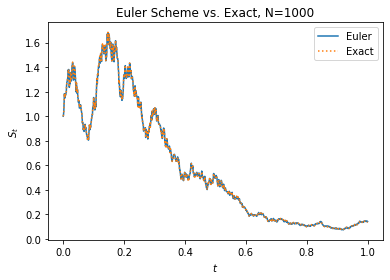

In [7]:
N = 1000  #Try changing N to 100, then 10!
np.random.seed(0)
tvec, S1 = gbmsim(1, N)  #S0=1, mu = 0, sigma = 1
np.random.seed(0)  #Use the same seed, otherwise we'd get different paths.
tvec, X = bmsim(1, N, 0, -.5, 1)  #BM with X0=0, a mean equal to nu = mu - .5*sigma**2 = -.5, and sigma = 1
S2 = np.exp(X)  #note: implicitly, S0=1 such that S2 = 1 * np.exp(X)
S1 = pd.Series(S1, index=tvec)
S2 = pd.Series(S2, index=tvec)
S1.plot()
S2.plot(linestyle=":")
plt.title("Euler Scheme vs. Exact, N="+str(N))
plt.xlabel("$t$")
plt.ylabel("$S_t$")
plt.legend(["Euler", "Exact"]);
#plt.savefig("img/GBMsim_eulervexact.svg"); plt.close()

<img src="img/GBMsim_eulervexact_N1000.svg" alt="Euler scheme versus Exact" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

<img src="img/GBMsim_eulervexact_N100.svg" alt="Euler scheme versus Exact" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

<img src="img/GBMsim_eulervexact_N10.svg" alt="Euler scheme versus Exact" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

* Intuition for Ito's lemma: (see Hull, 2012, Appendix to Ch. 13): In standard calculus, the total differential
<br><br>
$$
df=\dot{f}(t,g(t))dt+f^{\prime }(t,g(t))dg(t)
$$
<br>is the linear part of a Taylor expansion; the remaining terms
are of smaller order as $dt, dg(t) \to 0$. <br> So the total differential is a local linear approximation to $f$.


* If $g(t)=X_t$, an Ito process, take a 2nd order Taylor approximation:

\begin{align*}
&\Delta f\approx \dot{f}(t,X_{t})\Delta t+f^{\prime
}(t,X_{t})\Delta X_{t} +\frac{1}{2}\left[ \frac{\partial ^{2}f}{%
\partial t^{2}}(\Delta t)^{2}+2\frac{\partial ^{2}f}{\partial t\partial X_{t}%
}(\Delta t)(\Delta X_{t})+\frac{\partial ^{2}f}{\partial X_{t}^{2}}(\Delta
X_{t})^{2}\right].
\end{align*}

* We have that $\Delta X_{t}\equiv (X_{t}-X_{t-\Delta t})\approx \mu_{t-\Delta t} \Delta t + \sigma_{t-\Delta t} \Delta W_{t} \sim N(\mu_{t-\Delta t} \Delta t,\sigma^2_{t-\Delta t} \Delta t)$. Thus, $\mathbb{E} [(\Delta X_{t})^2]\approx (\mu_{t-\Delta t}\Delta t)^2+\sigma^2_{t-\Delta t}\Delta t\approx \sigma^2_{t-\Delta t}\Delta t $; i.e., the 2nd order term is of the same order
of magnitude as the 1st order term $\Delta t$. 
* It can be shown that as $\Delta t\rightarrow 0$, $(\Delta X_{t})^{2}$ can be treated as non-stochastic: $(dX_{t})^{2}=\sigma _{t}^{2}dt$.
Together with $(dt)^{2}=0$ and $(dt)(dX_{t})=0$, this gives the result.

## The Black-Scholes Model

* Black and Scholes assumed the following model:
  * The stock $\{S_{t}\}_{t\in \lbrack 0,T]}$ follows GBM:
$$
dS_{t} =\mu S_{t}dt+\sigma S_{t}dW_{t}.
$$

  * The stock pays no dividends.
  * Cash bond price $B_{t}=e^{rt}\Longleftrightarrow dB_{t}=rB_{t}dt$; riskless lending and borrowing at the same rate $r$.
  * European style derivative with price $C_{t}$ and payoff $C_{T}=(S_{T}-K)^+$.
  * Trading may occur continuously, with no transaction costs.
  * No arbitrage opportunities.
* The problem is to find the price $C_{t},t\in \lbrack 0,T]$. 

* It can be shown that the FTAP holds in continuous time as well: if the market is arbitrage free, then there exists a risk neutral measure $\mathbb{Q}$ under which all assets earn the risk free rate (on average), and the price of a claim is the discounted expected payoff under $\mathbb{Q}$. If the market is complete, then $\mathbb{Q}$ is unique. This gives us a pricing formula for general European claims:
$$
C_{t}=e^{-r(T-t)}\mathbb{E}^{\mathbb{Q}}\left[ \left.
C_{T}\right\vert \mathcal{F}_{t}\right] .
$$
* This implies that if we can simulate the stock price under the measure $\mathbb{Q}$, then we can price the claim by Monte Carlo simulation.

* In the BS model, it can be shown that under the risk-neutral measure $\mathbb{Q}$,
<br><br>
$$
dS_{t} =r S_{t}dt+\sigma S_{t}dW_{t}.
$$
<br>
* Note that by Ito's lemma, the discounted stock price $\tilde{S}_t\equiv e^{-rt}S_t=:f(t,S_t)$ satisfies

\begin{align*}
d\tilde{S}_t&= \dot{f}(t,S_t) dt + f'(t,S_t) dS_t +\frac{1}{2}f''(t,S_t) \sigma^2 S_t^2 dt\\
&=-re^{-rt}S_tdt+e^{-rt}dS_t+0\\
&=-r\tilde{S}_tdt+e^{-rt}(r S_{t}dt+\sigma S_{t}dW_{t} )\\
&=\sigma \tilde{S}_{t}dW_{t}.
\end{align*}
* I.e., $\tilde{S}_t$ is an Ito process without drift, and thus a martingale. This is the reason that $\mathbb{Q}$ is also called the equivalent martingale measure.

* We can extend the BS model by assuming that the underlying pays a continuous dividend at rate $q $ (realistic only for indices, not individual stocks). Then a position of 1 share generates an instantaneous dividend stream $q S_{t}dt$, in addition to the capital gains $dS_{t}$. Note that only the holder of the underlying receives the dividend.
* The pricing formula remains the same, but now the risk-neutral dynamics of $S_{t}$ are
$$
dS_{t}=(r-q )S_{t}dt+\sigma S_{t}dW_{t}.
$$
* The expected growth rate of the underlying under $\mathbb{Q}$ is $r-q $, so the expected return from holding it (capital gains plus dividend yield) is $r$.
* The price of a call is now
$$
C_{t}=e^{-q (T-t)}S_{t}\Phi (d_{1})-e^{-r(T-t)}K\Phi (d_{2}),
$$
where
$$
d_{1,2}=\frac{\log (S_{t}/K)+[(r-q )\pm \frac{1}{2}\sigma ^{2}](T-t)}{\sigma \sqrt{T-t}}.
$$

## Monte Carlo Pricing
* The goal in Monte Carlo simulation is to obtain an estimate of
$$
\theta\equiv \mathbb{E}[X],
$$
for some random variable $X$ with finite expectation. The assumption is that we have a means of sampling from the distribution of $X$, but no closed-form expression for $\theta$. 
* Suppose we have a sample $\{X_i\}_{i\in\{1,\ldots,n\}}$ of *independent* draws for $X$, and let
$$
\bar{X}_n=\frac{1}{n}\sum_{i=1}^n X_i.
$$
* The sample average $\bar{X}_n$ is an *unbiased estimator* of $\theta$ : $\mathbb{E}[\bar{X}_n]=\theta$.
* The *weak law of large numbers* states that
$$
\bar{X}_n\stackrel p \rightarrow \theta,
$$
where the arrow denotes *convergence in probability*; i.e., as the sample size grows, $\bar X_n$ becomes a better and better estimate of $\theta$.

* Thus, our strategy is to use a computer to draw $n$ (pseudo) random numbers $X_i$ from the distribution of $X$, and then estimate $\theta$ as the sample mean of the $X_i$.
* $n$ is called the number of *replications*.
* For finite $n$, the sample average will be an approximation to $\theta$. 
* It is usually desirable to have an estimate of the accuracy of this approximation. Such an estimate can be obtained from the *central limit theorem* (CLT), which states that
$$
\sqrt{n}(\bar{X}_n-\theta)\stackrel d\rightarrow N\left(0,\sigma^2\right),
$$
provided that $\sigma^2$, the variance of $X$, is finite. The arrow denotes convergence in distribution; this implies that for large $n$, $\bar{X}_n$ has approximately a normal distribution.
* Of course $\sigma^2$ is unknown, but we can estimate it as
$$
\hat{\sigma}^2=\frac{1}{n}\sum_{i=1}^n \left(\bar{X}_n-X_i\right)^2.
$$

* A 95% *confidence interval* (CI) is an interval $[c_l,c_u]$ with
$
\mathbb{P}[c_l\leq \theta \leq c_u]=0.95.
$
* The CLT implies that, in the limit as $n\rightarrow\infty$,

\begin{align*}
\mathbb{P}[-1.96 \sigma\leq \sqrt{n}(\bar{X}_n-\theta)\leq 1.96 \sigma ]&=0.95\Leftrightarrow\\
\mathbb{P}[\bar{X}_n-1.96 \frac{\sigma}{\sqrt{n}}\leq \theta\leq \bar{X}_n+1.96 \frac{\sigma}{\sqrt{n}} ]&=0.95.
\end{align*}
* Hence $c_l=\bar{X}_n-1.96 \frac{\sigma}{\sqrt{n}}$ and $c_u=\bar{X}_n+1.96 \frac{\sigma}{\sqrt{n}}$ is an asymptotically valid CI.
* Note that $c_l$ and $c_u$ are random variables; we should interpret this as "before the experiment is performed, there is a 95% chance that a CI computed according to this formula will contain $\theta$". After performing the experiment, this statement is not valid anymore; the interval is now fixed, and contains $\theta$ with probability either 0 or 1.
* The unknown parameter $\sigma$ can be consistently estimated by $\sqrt{\hat{\sigma}^2}$.

## Application: Asian Options
* The payoff of Asian options depends on the *average* price of the underlying, $\bar{S}_T$. Types:
  * Average price Asian call with payoff $(\bar{S}_T-K)^+$;
  * Average price Asian put with payoff $(K-\bar{S}_T)^+$;
  * Average strike Asian call with payoff $(S_T-\bar{S}_T)^+$;
  * Average strike Asian put with payoff $(\bar{S}_T-S_T)^+$.
* It is important to specify how the average is computed: the continuous,  arithmetic, and geometric averages are, respectively,
$$
\frac{1}{T}\int_0^T S_t dt,\qquad
\frac{1}{N}\sum_{i=1}^N S_{t_i},\qquad\mbox{and}\qquad\left(\prod_{i=1}^N S_{t_i}\right)^{1/N},
$$
where the $t_i$ are a set of $N$ specified dates.

* Exact Black-Scholes type pricing formulas for Asian options only exist in special cases (e.g., the geometric average Asian call), so we rely on Monte Carlo simulation.
* Our pricing formula
$$
C_{t}=e^{-r(T-t)}\mathbb{E}^{\mathbb{Q}}\left[ \left.
C_{T}\right\vert \mathcal{F}_{t}\right] 
$$
is exactly in the required form.
* As an example, consider pricing an arithmetic average price call with payoff
$$
C_T=(\bar{S}_T-K)^+,\quad\mbox{where}\quad \bar{S}_T=\frac{1}{N}\sum_{i=1}^N S_{t_i},
$$
which cannot be priced analytically.
* The payoff is *path-dependent*, so we need to simulate the entire asset price path, not just $S_T$.

In [8]:
from scipy.stats import norm
def asianmc(S0, K, T, r, sigma, q, N, numsim=10000):
    """Monte Carlo price of an arithmetic average Asian call."""
    X0 = np.log(S0)
    nu = r-q-.5*sigma**2
    payoffs = np.zeros(numsim)
    for i in range(numsim):
        _, X = bmsim(T, N, X0, nu, sigma)  #Convention: underscore holds value to be discarded.
        S = np.exp(X)
        payoffs[i] = max(S[1:].mean()-K, 0.)  #We ignore S0 in the mean.
    g = np.exp(-r*T)*payoffs
    C = g.mean(); s = g.std()
    zq = norm.ppf(0.975)
    Cl = C-(zq*s)/np.sqrt(numsim)
    Cu = C+(zq*s)/np.sqrt(numsim)
    return C, Cl, Cu

In [9]:
S0 = 11; K = 10; T = 3/12.; r = 0.02; sigma = .3; q = 0.01; N = 10
np.random.seed(0)
C0, Cl, Cu = asianmc(S0, K, T, r, sigma, q, N); C0, Cl, Cu

(1.0927262054551385, 1.0747653929130998, 1.1106870179971773)

## Code Optimization
* Our code for pricing the Asian option is likely inefficient, because it contains a loop.
* The code can be 'vectorized' to speed it up. 
* First step: simulate a bunch of Brownian paths in one shot.
* The resulting code is actually almost identical:

In [10]:
def bmsim_vec(T, N, X0=0, mu=0, sigma=1, numsim=1):  #Note new input: numsim, the number of paths.
    """Simulate `numsim` Brownian motion paths."""
    deltaT = float(T)/N
    tvec = np.linspace(0, T, N+1)
    z = np.random.randn(numsim, N+1)  #(N+1)->(numsim, N+1)
    dX = mu*deltaT + sigma*np.sqrt(deltaT)*z
    dX[:, 0] = 0.  #dX[0]->dX[:, 0]
    X = np.cumsum(dX, axis=1)  #cumsum(dX)->cumsum(dX, axis=1)
    X += X0    
    return tvec, X

In [11]:
np.random.seed(0) 
tvec, W = bmsim_vec(1, 1000, numsim=3)
W = pd.DataFrame(W.transpose(), index=tvec)
W.plot().legend().remove()
plt.title('Simulated Brownian Motion Paths')
plt.xlabel("$t$"); plt.ylabel("$W_t$");
plt.savefig("img/BMpaths.svg"); plt.close()

<img src="img/BMpaths.svg" alt="Simulated Brownian Motion Paths" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

* Here is the vectorized code for the Asian option:

In [12]:
def asianmc_vec(S0, K, T, r, sigma, q, N, numsim=10000):
    """Monte Carlo price of an arithmetic average Asian call."""
    X0 = np.log(S0)
    nu = r-q-.5*sigma**2    
    #simulate all paths at once:
    _, X = bmsim_vec(T, N, X0, nu, sigma, numsim)
    S = np.exp(X)
    payoffs = np.maximum(S[:, 1:].mean(axis=1)-K, 0.)  #S[1:]->S[:, 1:], max->maximum, mean()->mean(axis=1)
    g = np.exp(-r*T)*payoffs
    C = g.mean(); s = g.std()
    zq = norm.ppf(0.975)
    Cl = C - zq/np.sqrt(numsim)*s
    Cu = C + zq/np.sqrt(numsim)*s
    return C, Cl, Cu

* Let's see if it works:

In [13]:
np.random.seed(0)
C0_vec, _, _ = asianmc_vec(S0, K, T, r, sigma, q, N)
np.allclose(C0_vec, C0)

True

* And time it:

In [14]:
%timeit asianmc(S0, K, T, r, sigma, q, N)

389 ms ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit asianmc_vec(S0, K, T, r, sigma, q, N)

3.86 ms ± 321 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


* Our code for the Euler scheme can likewise be adjusted to compute many paths in one shot. 
* We're still stuck with the loop over $t$ though, which cannot be vectorized because $S_{i+1}$ depends on $S_i$.
* We'll use Numba's JIT compiler to speed it up further.

In [16]:
from numba import jit
@jit(nopython=True)
def gbmsim_vec(T, N, S0=1, mu=0, sigma=1, numsim=1, seed=0):
    """Simulate `numsim` Geometric Brownian motion paths."""
    deltaT = float(T)/N
    tvec = np.linspace(0, T, N+1)
    np.random.seed(seed)  #Note: with jit-compiled functions, the RNG must be seeded INSIDE the compiled code.
    z = np.random.randn(numsim, N+1)
    S = np.zeros_like(z)
    S[:, 0] = S0
    for i in range(0, N):
        S[:, i+1]=S[:, i] + mu*S[:, i]*deltaT + sigma*S[:, i]*np.sqrt(deltaT)*z[:, i+1]
    return tvec, S

In [17]:
tvec, S = gbmsim_vec(1, 1000, numsim=3, seed=0)
S = pd.DataFrame(S.transpose(), index=tvec)
S.plot().legend().remove()
plt.title('Simulated Geometric Brownian Motion Paths')
plt.xlabel("$t$"); plt.ylabel("$S_t$")
plt.savefig("img/GBMpaths.svg"); plt.close()

<img src="img/GBMpaths.svg" alt="Simulated Geometric Brownian Motion Paths" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

* The compiled code produces the same results:

In [18]:
np.random.seed(0)
_, S1 = gbmsim(1, 1000)
_, S2 = gbmsim_vec(1, 1000, seed=0)
np.allclose(S1, S2)

True

* But it is quite a bit faster:

In [19]:
%%timeit #Use double '%%' cell magic (for timing the entire cell).
for k in range(10):  #10 paths.
    gbmsim(1, 1000)

17.4 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%timeit gbmsim_vec(1, 1000, numsim=10)

312 µs ± 42.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Summary

* Stochastic calculus
    * A sequence of random variables is called a **stochastic process**, and the **stochastic difference equation** describes its dynamics.
    * The **Brownian Motion** is the building block for stochastic processes in continuous time.
    * An **Ito process** generalizes the BM by allowing the drift and volatility to be time-varying.
    * **Ito's lemma** allows to derive the (exact) SDE of $f(t,X_t)$, based on the dynamics of $X_t$ -- it avoids an **Euler approximation** for simulating the GBM.
    * The **Black-Scholes Model** is derived assuming a GBM for the stock price dynamics.

* Monte Carlo pricing
    * Pseudo random numbers are used to simulate values for $X_t$. 
    * Averaging over these draws provides an unbiased estimate of $E[X_t]$. 
    * The accuracy improves as we increase the number of replications $n$.
* Code can be optimized using **vectorization** and **`numba`** compiler.

<section id="copyrightslide">

# Copyright Statement
* Course slides were created by Simon Broda for Python 2.7 $-$ Andreas Rapp adapted them to Python 3.6. Maintained and updated by Bart Keijsers.
* Week 4 slides were created by Bart Keijsers.
* All figures have been produced for this course using Python. Empirical results are based on public data available from [FRED](https://fred.stlouisfed.org/), [Quandl/WIKI](https://www.quandl.com/databases/WIKIP), [Kenneth French's website](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) and [Yahoo Finance](https://finance.yahoo.com/).
* This work is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/).
* More information on Simon Broda's [Github](https://github.com/s-broda/ComputationalFinance/blob/master/LICENSE.md).